In [2]:
# Imports
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Define the input variables
delta_P = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Average active power')
O_cpv = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'Optimization potential of a CPV')

# Define the output variable
P_cpv = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'Priority number')

# Generate  membership functions for delta P
delta_P['low'] = fuzz.trapmf(delta_P.universe, [0, 0, 0.30, 0.4])
delta_P['medium'] = fuzz.trimf(delta_P.universe, [0.2, 0.5, 0.8])
delta_P['high'] = fuzz.trapmf(delta_P.universe, [0.7, 0.9, 1, 1])

# Generate  membership functions for optimization potential of a CPV
O_cpv['low'] = fuzz.trapmf(O_cpv.universe, [0, 0, 0.10, 0.15])
O_cpv['medium'] = fuzz.trimf(O_cpv.universe, [0.2, 0.5, 0.8])
O_cpv['high'] = fuzz.trapmf(O_cpv.universe, [ 0.7, 0.9, 1, 1])

# Generate  membership functions for priority number
P_cpv['low'] = fuzz.trapmf(P_cpv.universe, [0, 0, 0.20, 0.4])
P_cpv['medium'] = fuzz.trimf(P_cpv.universe, [0.2, 0.5, 0.8])
P_cpv['high'] = fuzz.trapmf(P_cpv.universe, [0.7, 0.9, 1, 1])

# Define fuzzy rule base
rule1 = ctrl.Rule(delta_P['high'] | O_cpv['low'], P_cpv['high'])
rule2 = ctrl.Rule(delta_P['medium'] | O_cpv['low'], P_cpv['medium'])
rule3 = ctrl.Rule(delta_P['low'] | O_cpv['low'], P_cpv['medium'])
rule4 = ctrl.Rule(delta_P['high'] | O_cpv['medium'], P_cpv['medium'])
rule5 = ctrl.Rule(delta_P['medium'] | O_cpv['medium'], P_cpv['medium'])
rule6 = ctrl.Rule(delta_P['low'] | O_cpv['medium'], P_cpv['medium'])
rule7 = ctrl.Rule(delta_P['high'] | O_cpv['high'], P_cpv['medium'])
rule8 = ctrl.Rule(delta_P['medium'] | O_cpv['high'], P_cpv['medium'])
rule9 = ctrl.Rule(delta_P['low'] | O_cpv['high'], P_cpv['low'])

# Create the control system
P_cpv_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4, rule5, rule6,rule7, rule8, rule9])
P_cpv_ctrl_simulation = ctrl.ControlSystemSimulation(P_cpv_ctrl)

<Figure size 600x400 with 0 Axes>

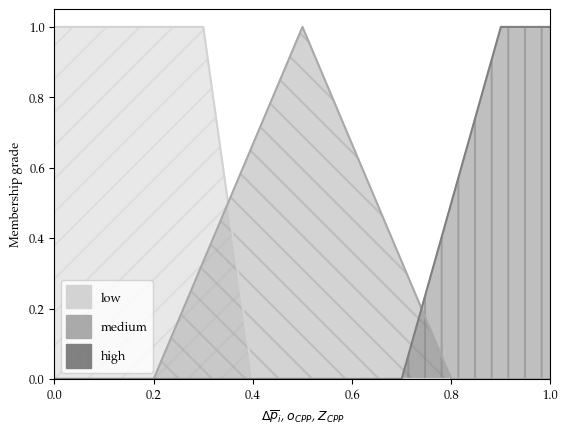

In [7]:
# Set font properties
rcParams['font.family'] = 'Palatino Linotype'
rcParams['font.size'] = 9
plt.rcParams['hatch.linewidth'] = 1.5  # Default is 1.0
hatch='////'  # More dense hatching

fig = plt.figure(figsize=(6, 4))
fig.tight_layout(pad=5.0)

def visualize_fuzzy_variable(ax, fuzzy_var, xlabel, ylabel, grey_colors, hatches):
    fig, ax = plt.subplots()
    legend_patches = []  # Store patches for legend

    for i, term in enumerate(fuzzy_var.terms):
        universe = fuzzy_var.universe
        mf_values = fuzzy_var[term].mf

        # Plotting line and filling area with hatching
        ax.plot(universe, mf_values, color=grey_colors[i % len(grey_colors)])
        ax.fill_between(universe, 0, mf_values, color=grey_colors[i % len(grey_colors)], alpha=0.5, hatch=hatches[i % len(hatches)])

        # Create a patch for the legend that includes color and visible hatch
        # Set facecolor to 'none' to focus on the hatch pattern
        patch = mpatches.Patch(facecolor=grey_colors[i % len(grey_colors)], alpha=0.99,edgecolor=grey_colors[i % len(grey_colors)],
                               hatch=hatches[i % len(hatches)] * 2, label=term)  # Increase hatch visibility
        legend_patches.append(patch)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

    # Add legend with custom patches, handle the visibility of hatches
    ax.legend(handles=legend_patches, loc='best', handleheight=2.5, handlelength=2)

    return fig, ax

# Define colors and hatches
grey_colors = ['#d3d3d3', '#a9a9a9', '#808080', '#696969', '#505050']  # Light to dark grey
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Different hatching styles

# Assuming delta_P and other fuzzy variables are already defined
# Example usage of the visualization function
fig, ax = visualize_fuzzy_variable(ax,delta_P,  r'$\Delta \overline{p}_{i}$, $o_{CPP}$, $Z_{CPP}$', 'Membership grade', grey_colors, hatches)

plt.show()

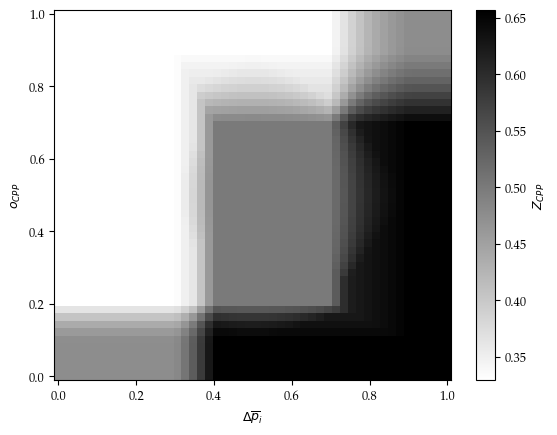

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Set font properties
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 9

# Assuming P_cpv_ctrl_simulation, delta_P_values, and O_cpv_values are defined as before

# Generate input value grids
delta_P_values = np.linspace(0, 1, 50)  # Fine granularity
O_cpv_values = np.linspace(0, 1, 50)
delta_P_grid, O_cpv_grid = np.meshgrid(delta_P_values, O_cpv_values)
P_cpv_grid = np.zeros_like(delta_P_grid)

# Simulate the grid
for i in range(delta_P_grid.shape[0]):
    for j in range(delta_P_grid.shape[1]):
        P_cpv_ctrl_simulation.input['Average active power'] = delta_P_grid[i, j]
        P_cpv_ctrl_simulation.input['Optimization potential of a CPV'] = O_cpv_grid[i, j]
        P_cpv_ctrl_simulation.compute()
        P_cpv_grid[i, j] = P_cpv_ctrl_simulation.output['Priority number']

# Create the heatmap
fig, ax = plt.subplots()

c = ax.pcolormesh(delta_P_grid, O_cpv_grid, P_cpv_grid, cmap='gray_r', shading='auto')  # Use 'gray_r' for reversed grayscale
ax.set_xlabel('$\Delta \overline{p}_{i}$')
ax.set_ylabel('$o_{CPP}$')

# Add a color bar to represent the scale
colorbar = fig.colorbar(c, ax=ax)
colorbar.set_label('$Z_{CPP}$')  # Label the color axis

plt.show()
